# Library

In [1]:
pip install matplotlib

In [2]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
# Others
import shutil
import random

# Load dataset

In [4]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Corn/train",
    label_mode="categorical",
    class_names=['Corn Gray leaf spot','Corn healthy','Corn leaf blight','Corn rust leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Corn/valid",
    label_mode="categorical",
    class_names=['Corn Gray leaf spot','Corn healthy','Corn leaf blight','Corn rust leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 7665 files belonging to 4 classes.
==========================Validation Data====================
Found 1855 files belonging to 4 classes.


In [5]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale = 1.0/256.)
test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("Dataset/Corn/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("Dataset/Corn/valid",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 7665 images belonging to 4 classes.
Found 1855 images belonging to 4 classes.


# List Resource

In [6]:
# Check GPU
!nvidia-smi

Thu May 25 08:38:02 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.79                 Driver Version: 531.79       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 L...  WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   53C    P0               40W /  N/A|   4573MiB /  6144MiB |     10%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Modelling Without Augmentation

## DenseNet Model 1

In [9]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Corn_DenseNet_model1_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [10]:
# Define DIY Model
DenseNet_model = tf.keras.models.Sequential([
    # DenseNet121 Layer
    DenseNet121(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
DenseNet_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DenseNet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_max_pooling2d (Globa  (None, 1024)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 7,300,932
Trainable params: 7,217,284
Non-trainable params: 83,648
_________________________________________

In [11]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DenseNet_model_1 = DenseNet_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
384/384 [==============================] - ETA: 0s - loss: 0.4291 - accuracy: 0.8908
Epoch 1: val_accuracy improved from -inf to 0.92507, saving model to Corn_DenseNet_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Non_Augmented\assets


384/384 [==============================] - 151s 348ms/step - loss: 0.4291 - accuracy: 0.8908 - val_loss: 0.2613 - val_accuracy: 0.9251 - lr: 0.0010
Epoch 2/100
384/384 [==============================] - ETA: 0s - loss: 0.2272 - accuracy: 0.9272
Epoch 2: val_accuracy improved from 0.92507 to 0.94717, saving model to Corn_DenseNet_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Non_Augmented\assets


384/384 [==============================] - 109s 283ms/step - loss: 0.2272 - accuracy: 0.9272 - val_loss: 0.1377 - val_accuracy: 0.9472 - lr: 0.0010
Epoch 3/100
384/384 [==============================] - ETA: 0s - loss: 0.1779 - accuracy: 0.9442
Epoch 3: val_accuracy did not improve from 0.94717
384/384 [==============================] - 74s 192ms/step - loss: 0.1779 - accuracy: 0.9442 - val_loss: 21.6901 - val_accuracy: 0.7650 - lr: 0.0010
Epoch 4/100
384/384 [==============================] - ETA: 0s - loss: 0.1815 - accuracy: 0.9367
Epoch 4: val_accuracy improved from 0.94717 to 0.95202, saving model to Corn_DenseNet_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Non_Augmented\assets


384/384 [==============================] - 113s 295ms/step - loss: 0.1815 - accuracy: 0.9367 - val_loss: 0.1384 - val_accuracy: 0.9520 - lr: 0.0010
Epoch 5/100
384/384 [==============================] - ETA: 0s - loss: 0.1283 - accuracy: 0.9538
Epoch 5: val_accuracy improved from 0.95202 to 0.96766, saving model to Corn_DenseNet_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Non_Augmented\assets


384/384 [==============================] - 121s 315ms/step - loss: 0.1283 - accuracy: 0.9538 - val_loss: 0.0836 - val_accuracy: 0.9677 - lr: 0.0010
Epoch 6/100
384/384 [==============================] - ETA: 0s - loss: 0.1127 - accuracy: 0.9585
Epoch 6: val_accuracy did not improve from 0.96766
384/384 [==============================] - 76s 196ms/step - loss: 0.1127 - accuracy: 0.9585 - val_loss: 0.1058 - val_accuracy: 0.9574 - lr: 0.0010
Epoch 7/100
384/384 [==============================] - ETA: 0s - loss: 0.1080 - accuracy: 0.9598
Epoch 7: val_accuracy did not improve from 0.96766
384/384 [==============================] - 77s 200ms/step - loss: 0.1080 - accuracy: 0.9598 - val_loss: 0.1876 - val_accuracy: 0.9202 - lr: 0.0010
Epoch 8/100
384/384 [==============================] - ETA: 0s - loss: 0.0955 - accuracy: 0.9667
Epoch 8: val_accuracy did not improve from 0.96766
384/384 [==============================] - 76s 199ms/step - loss: 0.0955 - accuracy: 0.9667 - val_loss: 0.6726 - v

INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Non_Augmented\assets


384/384 [==============================] - 121s 315ms/step - loss: 0.0880 - accuracy: 0.9716 - val_loss: 0.0820 - val_accuracy: 0.9682 - lr: 0.0010
Epoch 11/100
384/384 [==============================] - ETA: 0s - loss: 0.1174 - accuracy: 0.9593
Epoch 11: val_accuracy improved from 0.96819 to 0.96927, saving model to Corn_DenseNet_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Non_Augmented\assets


384/384 [==============================] - 118s 307ms/step - loss: 0.1174 - accuracy: 0.9593 - val_loss: 0.0871 - val_accuracy: 0.9693 - lr: 0.0010
Epoch 12/100
384/384 [==============================] - ETA: 0s - loss: 0.1031 - accuracy: 0.9637
Epoch 12: val_accuracy improved from 0.96927 to 0.96981, saving model to Corn_DenseNet_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Non_Augmented\assets


384/384 [==============================] - 119s 309ms/step - loss: 0.1031 - accuracy: 0.9637 - val_loss: 0.0874 - val_accuracy: 0.9698 - lr: 0.0010
Epoch 13/100
384/384 [==============================] - ETA: 0s - loss: 0.0869 - accuracy: 0.9680
Epoch 13: val_accuracy did not improve from 0.96981
384/384 [==============================] - 74s 193ms/step - loss: 0.0869 - accuracy: 0.9680 - val_loss: 0.1943 - val_accuracy: 0.9202 - lr: 0.0010
Epoch 14/100
384/384 [==============================] - ETA: 0s - loss: 0.0839 - accuracy: 0.9697
Epoch 14: val_accuracy did not improve from 0.96981
384/384 [==============================] - 75s 195ms/step - loss: 0.0839 - accuracy: 0.9697 - val_loss: 0.1072 - val_accuracy: 0.9698 - lr: 0.0010
Epoch 15/100
384/384 [==============================] - ETA: 0s - loss: 0.0885 - accuracy: 0.9665
Epoch 15: val_accuracy did not improve from 0.96981

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
384/384 [====================

INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Non_Augmented\assets


384/384 [==============================] - 123s 319ms/step - loss: 0.0408 - accuracy: 0.9847 - val_loss: 0.0471 - val_accuracy: 0.9844 - lr: 1.0000e-04
Epoch 17/100
384/384 [==============================] - ETA: 0s - loss: 0.0364 - accuracy: 0.9879
Epoch 17: val_accuracy improved from 0.98437 to 0.98491, saving model to Corn_DenseNet_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Non_Augmented\assets


384/384 [==============================] - 119s 310ms/step - loss: 0.0364 - accuracy: 0.9879 - val_loss: 0.0434 - val_accuracy: 0.9849 - lr: 1.0000e-04
Epoch 18/100
384/384 [==============================] - ETA: 0s - loss: 0.0297 - accuracy: 0.9905
Epoch 18: val_accuracy did not improve from 0.98491
384/384 [==============================] - 75s 194ms/step - loss: 0.0297 - accuracy: 0.9905 - val_loss: 0.0523 - val_accuracy: 0.9833 - lr: 1.0000e-04
Epoch 19/100
384/384 [==============================] - ETA: 0s - loss: 0.0280 - accuracy: 0.9888
Epoch 19: val_accuracy did not improve from 0.98491
384/384 [==============================] - 75s 195ms/step - loss: 0.0280 - accuracy: 0.9888 - val_loss: 0.0431 - val_accuracy: 0.9849 - lr: 1.0000e-04
Epoch 20/100
384/384 [==============================] - ETA: 0s - loss: 0.0249 - accuracy: 0.9907
Epoch 20: val_accuracy did not improve from 0.98491
384/384 [==============================] - 76s 197ms/step - loss: 0.0249 - accuracy: 0.9907 - va

INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Non_Augmented\assets


384/384 [==============================] - 120s 313ms/step - loss: 0.0221 - accuracy: 0.9928 - val_loss: 0.0489 - val_accuracy: 0.9860 - lr: 1.0000e-04
Epoch 23/100
384/384 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9954
Epoch 23: val_accuracy did not improve from 0.98598
384/384 [==============================] - 75s 194ms/step - loss: 0.0147 - accuracy: 0.9954 - val_loss: 0.0563 - val_accuracy: 0.9849 - lr: 1.0000e-04
Epoch 24/100
384/384 [==============================] - ETA: 0s - loss: 0.0128 - accuracy: 0.9954
Epoch 24: val_accuracy did not improve from 0.98598

Epoch 24: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
384/384 [==============================] - 76s 197ms/step - loss: 0.0128 - accuracy: 0.9954 - val_loss: 0.0607 - val_accuracy: 0.9822 - lr: 1.0000e-04
Epoch 25/100
384/384 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 0.9966
Epoch 25: val_accuracy did not improve from 0.98598
384/384 [========

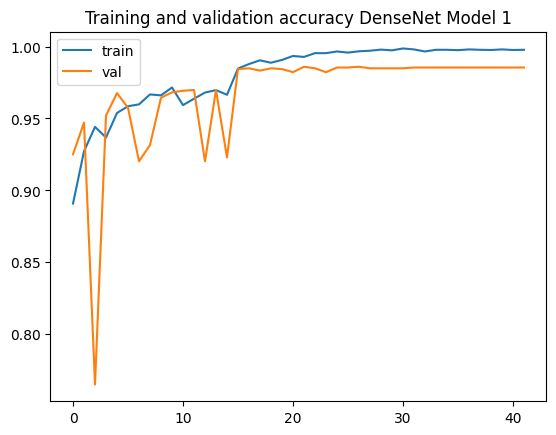

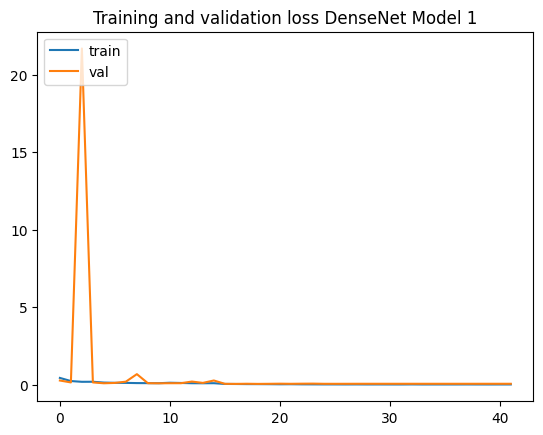

In [12]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DenseNet_model_1.history['accuracy' ]
val_acc  = history_DenseNet_model_1.history['val_accuracy' ]
loss     = history_DenseNet_model_1.history['loss' ]
val_loss = history_DenseNet_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DenseNet Model 1')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DenseNet Model 1')
plt.legend(['train', 'val'], loc='upper left')

## DenseNet Model 2

In [13]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Corn_DenseNet_model2_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [14]:
# Define DIY Model
DenseNet_model_2 = tf.keras.models.Sequential([
    # DenseNet121 Layer
    DenseNet121(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
DenseNet_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DenseNet_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 7,300,932
Trainable params: 7,217,284
Non-trainable params: 83,648
_______________________________________

In [15]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DenseNet_model_2 = DenseNet_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
384/384 [==============================] - ETA: 0s - loss: 0.2676 - accuracy: 0.9045
Epoch 1: val_accuracy improved from -inf to 0.91698, saving model to Corn_DenseNet_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Corn_DenseNet_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DenseNet_model2_Based_Non_Augmented\assets


384/384 [==============================] - 128s 306ms/step - loss: 0.2676 - accuracy: 0.9045 - val_loss: 0.2764 - val_accuracy: 0.9170 - lr: 0.0010
Epoch 2/100
384/384 [==============================] - ETA: 0s - loss: 0.1644 - accuracy: 0.9405
Epoch 2: val_accuracy did not improve from 0.91698
384/384 [==============================] - 74s 191ms/step - loss: 0.1644 - accuracy: 0.9405 - val_loss: 0.4872 - val_accuracy: 0.7871 - lr: 0.0010
Epoch 3/100
384/384 [==============================] - ETA: 0s - loss: 0.1420 - accuracy: 0.9461
Epoch 3: val_accuracy did not improve from 0.91698
384/384 [==============================] - 74s 193ms/step - loss: 0.1420 - accuracy: 0.9461 - val_loss: 1.5759 - val_accuracy: 0.5245 - lr: 0.0010
Epoch 4/100
384/384 [==============================] - ETA: 0s - loss: 0.1433 - accuracy: 0.9491
Epoch 4: val_accuracy improved from 0.91698 to 0.97197, saving model to Corn_DenseNet_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Corn_DenseNet_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DenseNet_model2_Based_Non_Augmented\assets


384/384 [==============================] - 118s 308ms/step - loss: 0.1433 - accuracy: 0.9491 - val_loss: 0.0779 - val_accuracy: 0.9720 - lr: 0.0010
Epoch 5/100
384/384 [==============================] - ETA: 0s - loss: 0.1114 - accuracy: 0.9592
Epoch 5: val_accuracy improved from 0.97197 to 0.97466, saving model to Corn_DenseNet_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Corn_DenseNet_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DenseNet_model2_Based_Non_Augmented\assets


384/384 [==============================] - 118s 307ms/step - loss: 0.1114 - accuracy: 0.9592 - val_loss: 0.0752 - val_accuracy: 0.9747 - lr: 0.0010
Epoch 6/100
384/384 [==============================] - ETA: 0s - loss: 0.0994 - accuracy: 0.9639
Epoch 6: val_accuracy did not improve from 0.97466
384/384 [==============================] - 74s 193ms/step - loss: 0.0994 - accuracy: 0.9639 - val_loss: 0.1064 - val_accuracy: 0.9569 - lr: 0.0010
Epoch 7/100
384/384 [==============================] - ETA: 0s - loss: 0.1143 - accuracy: 0.9586
Epoch 7: val_accuracy did not improve from 0.97466
384/384 [==============================] - 75s 194ms/step - loss: 0.1143 - accuracy: 0.9586 - val_loss: 0.4236 - val_accuracy: 0.8733 - lr: 0.0010
Epoch 8/100
384/384 [==============================] - ETA: 0s - loss: 0.0982 - accuracy: 0.9637
Epoch 8: val_accuracy did not improve from 0.97466
384/384 [==============================] - 75s 196ms/step - loss: 0.0982 - accuracy: 0.9637 - val_loss: 0.0876 - v

INFO:tensorflow:Assets written to: Corn_DenseNet_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DenseNet_model2_Based_Non_Augmented\assets


384/384 [==============================] - 120s 312ms/step - loss: 0.0568 - accuracy: 0.9807 - val_loss: 0.0456 - val_accuracy: 0.9833 - lr: 1.0000e-04
Epoch 12/100
384/384 [==============================] - ETA: 0s - loss: 0.0417 - accuracy: 0.9854
Epoch 12: val_accuracy did not improve from 0.98329
384/384 [==============================] - 74s 193ms/step - loss: 0.0417 - accuracy: 0.9854 - val_loss: 0.0554 - val_accuracy: 0.9811 - lr: 1.0000e-04
Epoch 13/100
384/384 [==============================] - ETA: 0s - loss: 0.0338 - accuracy: 0.9885
Epoch 13: val_accuracy did not improve from 0.98329
384/384 [==============================] - 75s 196ms/step - loss: 0.0338 - accuracy: 0.9885 - val_loss: 0.0739 - val_accuracy: 0.9757 - lr: 1.0000e-04
Epoch 14/100
384/384 [==============================] - ETA: 0s - loss: 0.0316 - accuracy: 0.9897
Epoch 14: val_accuracy did not improve from 0.98329
384/384 [==============================] - 76s 198ms/step - loss: 0.0316 - accuracy: 0.9897 - va

INFO:tensorflow:Assets written to: Corn_DenseNet_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DenseNet_model2_Based_Non_Augmented\assets



Epoch 16: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
384/384 [==============================] - 126s 329ms/step - loss: 0.0219 - accuracy: 0.9932 - val_loss: 0.0581 - val_accuracy: 0.9849 - lr: 1.0000e-04
Epoch 17/100
384/384 [==============================] - ETA: 0s - loss: 0.0168 - accuracy: 0.9943
Epoch 17: val_accuracy improved from 0.98491 to 0.98598, saving model to Corn_DenseNet_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Corn_DenseNet_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DenseNet_model2_Based_Non_Augmented\assets


384/384 [==============================] - 118s 307ms/step - loss: 0.0168 - accuracy: 0.9943 - val_loss: 0.0547 - val_accuracy: 0.9860 - lr: 1.0000e-05
Epoch 18/100
384/384 [==============================] - ETA: 0s - loss: 0.0161 - accuracy: 0.9949
Epoch 18: val_accuracy improved from 0.98598 to 0.98760, saving model to Corn_DenseNet_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Corn_DenseNet_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DenseNet_model2_Based_Non_Augmented\assets


384/384 [==============================] - 116s 301ms/step - loss: 0.0161 - accuracy: 0.9949 - val_loss: 0.0552 - val_accuracy: 0.9876 - lr: 1.0000e-05
Epoch 19/100
384/384 [==============================] - ETA: 0s - loss: 0.0189 - accuracy: 0.9940
Epoch 19: val_accuracy did not improve from 0.98760
384/384 [==============================] - 77s 199ms/step - loss: 0.0189 - accuracy: 0.9940 - val_loss: 0.0558 - val_accuracy: 0.9876 - lr: 1.0000e-05
Epoch 20/100
384/384 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 0.9944
Epoch 20: val_accuracy did not improve from 0.98760
384/384 [==============================] - 77s 201ms/step - loss: 0.0143 - accuracy: 0.9944 - val_loss: 0.0568 - val_accuracy: 0.9871 - lr: 1.0000e-05
Epoch 21/100
384/384 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 0.9953
Epoch 21: val_accuracy did not improve from 0.98760

Epoch 21: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
384/384 [========

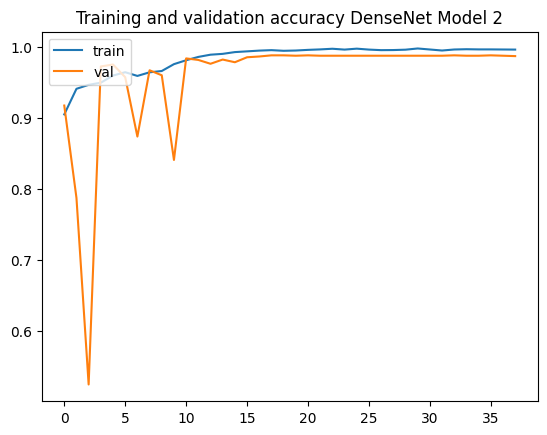

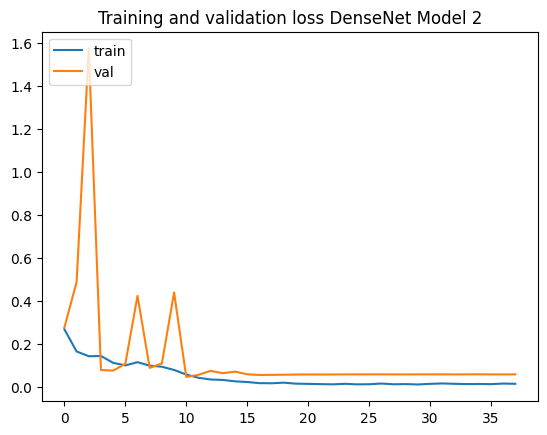

In [16]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DenseNet_model_2.history['accuracy' ]
val_acc  = history_DenseNet_model_2.history['val_accuracy' ]
loss     = history_DenseNet_model_2.history['loss' ]
val_loss = history_DenseNet_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DenseNet Model 2')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DenseNet Model 2')
plt.legend(['train', 'val'], loc='upper left')